In [5]:
pip install pandas numpy matplotlib scikit-learn lifelines sqlalchemy


  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'autograd-gamma' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'autograd-gamma'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=71166fcc840963daa0056b48d6801e20cfd15f4a213364bc0d38ce29c689a386
  Stored in directory: /Users/trisharaj/Library/Caches/pip/wheels/7e/16/46/9477f188924292d3bf1fb8fb42844201591abfc19b7ba6d868
Successfully built autograd-gamma
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [lifelines]/5 [lifelines]
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd, numpy as np

# Load raw dataset
df = pd.read_csv("Telco-Customer-Churn.csv")

# Fake signup month (cohorts) across 2 years
np.random.seed(42)
months = pd.date_range("2021-01-01", "2023-12-01", freq="MS")
df["signup_month"] = np.random.choice(months, size=len(df))

# Expand to customer-month rows
subs = []
for _, row in df.iterrows():
    for t in range(1, row["tenure"]+1):
        m = row["signup_month"] + pd.DateOffset(months=t-1)
        churn_flag = 1 if (t == row["tenure"] and row["Churn"]=="Yes") else 0
        subs.append([row["customerID"], m, row["MonthlyCharges"], row["Contract"], churn_flag])

subs = pd.DataFrame(subs, columns=["customer_id","month","mrr","contract_type","churn_flag"])
subs["cohort_month"] = subs.groupby("customer_id")["month"].transform("min")
subs["is_active"] = (subs["mrr"] > 0).astype(int)

subs.head()


,customer_id,month,mrr,contract_type,churn_flag,cohort_month,is_active
0,7590-VHVEG,2023-05-01,29.85,Month-to-month,0,2023-05-01,1
1,5575-GNVDE,2022-03-01,56.95,One year,0,2022-03-01,1
2,5575-GNVDE,2022-04-01,56.95,One year,0,2022-03-01,1
3,5575-GNVDE,2022-05-01,56.95,One year,0,2022-03-01,1
4,5575-GNVDE,2022-06-01,56.95,One year,0,2022-03-01,1


In [2]:
subs.to_csv("subscriptions.csv", index=False)


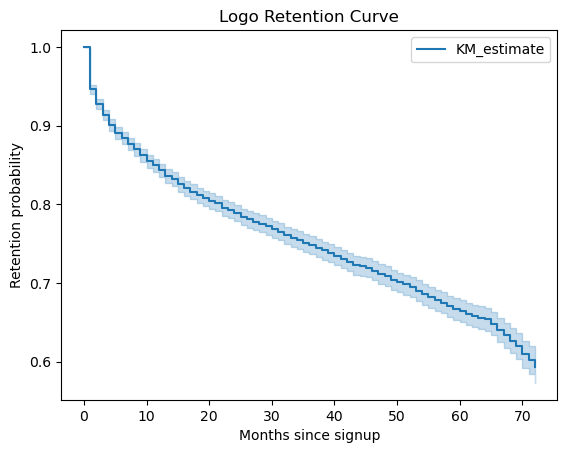

In [4]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

survival = subs.groupby("customer_id").agg(
    tenure=("month","count"),
    churned=("churn_flag","max")
).reset_index()

kmf = KaplanMeierFitter()
kmf.fit(durations=survival["tenure"], event_observed=survival["churned"])
kmf.plot()
plt.title("Logo Retention Curve")
plt.xlabel("Months since signup")
plt.ylabel("Retention probability")
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Label = churn next month
subs["next_active"] = subs.groupby("customer_id")["is_active"].shift(-1).fillna(0)
subs["churn_next"] = ((subs["is_active"]==1) & (subs["next_active"]==0)).astype(int)

features = pd.get_dummies(subs[["mrr","contract_type","churn_next"]], drop_first=True)
X = features.drop("churn_next",axis=1)
y = features["churn_next"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

model = LogisticRegression(max_iter=200,class_weight="balanced")
model.fit(X_train,y_train)

pred = model.predict_proba(X_test)[:,1]
print("ROC AUC:", roc_auc_score(y_test,pred))


ROC AUC: 0.6557315750873315


In [6]:
subs.to_csv("subs_export.csv",index=False)
